In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import pandas as pd
from xgboost import XGBClassifier
import matplotlib.pyplot as plt


In [6]:
in_df = pd.read_csv(
    "/Users/we56sc/Analytics/DataSets/Default_Of_Credit_Card_Clients/UCI_Credit_Card.csv"
)

In [411]:
import datetime as dt
def logger(f):
    def wrapper(df, *args, **kwargs):
        t_in = dt.datetime.now()
        out_df = f(df,*args,**kwargs)
        t_out = dt.datetime.now()
        print(f'Total time: {t_out-t_in}: Resulting shape: {out_df.shape}')
        return out_df
    return wrapper

@logger
def start_pipeline(df):
    return df.copy()

@logger
def process_data(df):
    return (
        df.drop('ID', axis=1)
        .drop(['SEX', 'EDUCATION', 'MARRIAGE'], axis=1)
        .rename(columns={'PAY_0':'PAY_1'})
    )

In [410]:
df = (
    in_df
    .pipe(start_pipeline)
    .pipe(process_data)
)

Total time: 0:00:00.011540: Resulting shape: (30000, 25)
Total time: 0:00:00.011877: Resulting shape: (30000, 21)


# Train Test split

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
 df.drop('default.payment.next.month', axis=1), 
 df['default.payment.next.month'], 
 test_size=0.33, random_state=42
)


In [22]:
evallist = [(dtest, 'eval'), (dtrain, 'train')]
eval_set = [
    (X_train, y_train),
    (X_test, y_test)   
]

# Train first xgb

In [71]:
def train_sequential_models(*models):
    
    results_seq = list()
    total_estimators = 0
    
    for ix,model in enumerate(models):
    
        total_estimators += model.n_estimators
        
        if ix==0: 
            init_params = model.get_params()
            bst = model.fit(
                X_train, y_train,
                eval_set = eval_set,
                eval_metric=['auc','logloss'],
                verbose=False
            )
        else:
            bst = model.fit(
                X_train, y_train,
                eval_set = eval_set,
                eval_metric=['auc','logloss'],
                verbose=False,
                xgb_model=f'model_{ix}'
            )
            
        bst.save_model(f'model_{ix+1}')
        result = model.evals_result()
        results_seq.append(result)
        
        
    # test
    init_params['n_estimators'] = total_estimators
    start_xgb = XGBClassifier(**init_params)
    start_xgb.fit(
                X_train, y_train,
                eval_set = eval_set,
                eval_metric=['auc','logloss'],
                verbose=False
    )
    results_init = start_xgb.evals_result()
        
    return results_seq, results_init, bst, start_xgb


In [127]:
XGBClassifier()

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='binary:logistic', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=False, verbosity=None)

In [315]:
from xgboost import plot_tree

In [327]:
list_models = [
    XGBClassifier(n_estimators=200, learning_rate = 0.3, max_depth=3, reg_lambda =1),
    XGBClassifier(n_estimators=200, learning_rate = 0.3, max_depth=3, reg_lambda =500),
    XGBClassifier(n_estimators=200, learning_rate = 0.3, max_depth=3, reg_lambda =1),
]

In [328]:
results_seq, results_init, model_seq, model_init = train_sequential_models(*list_models)

In [329]:
model_init

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=600, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [349]:
trees = (
    model_init
    .get_booster()
    .trees_to_dataframe()
)

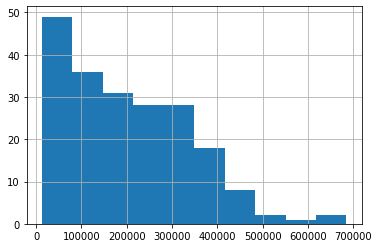

In [406]:
trees[trees.Feature=='LIMIT_BAL']['Split'].hist()

In [392]:
tree_pred =  pd.DataFrame(model_init.apply(X_test), columns = [f'tree_{i+1}' for i in range(model_init.n_estimators)])



In [400]:
tree_pred['tree_3'].value_counts()

8     4600
7     2637
12     993
13     589
14     422
9      282
11     253
10     124
Name: tree_3, dtype: int64

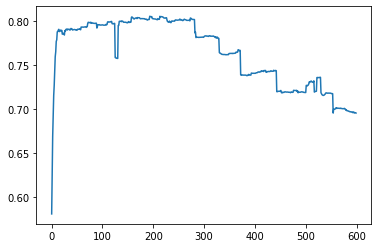

In [396]:
first_inst_pred = [
    model_init.predict_proba(X_test,ntree_limit=i_tree+1)[:,1][10]
    for i_tree in range(model_init.n_estimators)
]
plt.plot(first_inst_pred)

In [398]:
y_test.head(11)

2308     0
22404    0
23397    0
25058    0
2664     1
8511     0
5148     1
7790     0
11311    0
19043    0
10784    0
Name: default.payment.next.month, dtype: int64

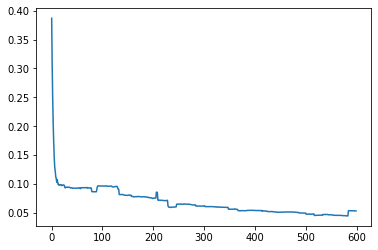

In [360]:
trees[trees.Tree==0]

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover
0,0,0,0-0,PAY_1,2.0,0-1,0-2,0-1,2125.537600,5025.00
1,0,1,0-1,PAY_2,2.0,0-3,0-4,0-3,433.202637,4495.25
2,0,2,0-2,PAY_3,0.0,0-5,0-6,0-5,37.068359,529.75
3,0,3,0-3,PAY_AMT3,573.5,0-7,0-8,0-7,133.999023,4116.25
4,0,4,0-4,PAY_3,1.0,0-9,0-10,0-9,29.467129,379.00
5,0,5,0-5,BILL_AMT1,2325.0,0-11,0-12,0-11,12.212393,33.00
6,0,6,0-6,PAY_5,1.0,0-13,0-14,0-13,21.398834,496.75
7,0,7,0-7,Leaf,NaN,NaN,NaN,NaN,-0.336994,1091.75
8,0,8,0-8,Leaf,NaN,NaN,NaN,NaN,-0.460486,3024.50
9,0,9,0-9,Leaf,NaN,NaN,NaN,NaN,-0.180083,179.75


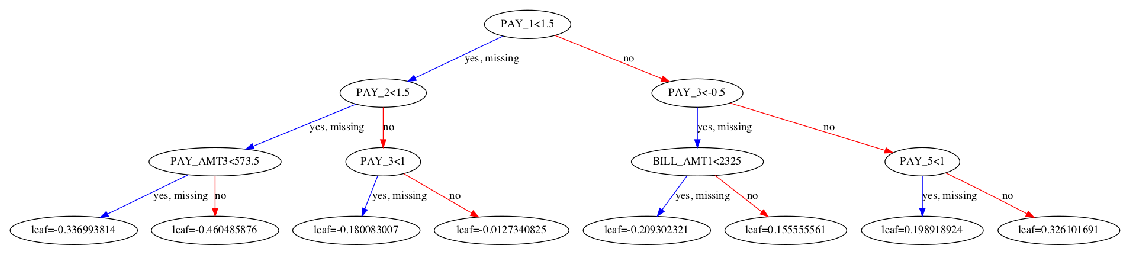

In [345]:
# 

fig, ax = plt.subplots(figsize =(20,20))
plot_tree(model_init,num_trees=0, rankdir='TB', ax = ax)

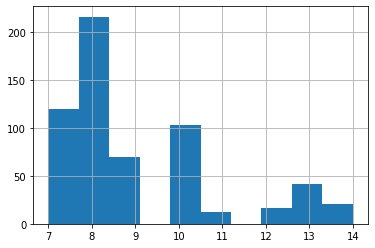

In [313]:
pd.Series(model_init.apply(X_test)[1]).hist()

### Map to df

In [177]:
def map_results(results, index=1):
    df_train = pd.DataFrame(results['validation_0'])
    df_train.columns = [f'{col}_train' for col in df_train.columns]

    df_test = pd.DataFrame(results['validation_1'])
    df_test.columns = [f'{col}_test' for col in df_test.columns]

    df = pd.concat([df_train,df_test], axis=1)
    
    df.loc[:,'training_index'] = index
    
    return df

In [178]:
init_results = map_results(results_init, 1)
seq_results = (
    pd.concat([map_results(result_seq, ix+1) for ix, result_seq in enumerate(results_seq)])
    .reset_index()
    .drop('index', axis=1)
)

In [179]:
init_results.tail(3)

,auc_train,logloss_train,auc_test,logloss_test,training_index
597,0.795514,0.420771,0.777799,0.428387,1
598,0.795552,0.420741,0.777799,0.428392,1
599,0.795601,0.420709,0.777801,0.428381,1


In [180]:
seq_results.tail(3)

,auc_train,logloss_train,auc_test,logloss_test,training_index
597,0.792119,0.423449,0.776791,0.428931,3
598,0.792145,0.423428,0.776805,0.428921,3
599,0.792169,0.423407,0.776820,0.428910,3


# Plotting

In [181]:
def plot(results_df, ax = None, start = 0):
    epochs = results_df.shape[0]
    
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis[start:], results_df['logloss_train'].values[start:], label='Train', color='darkgreen')
    ax.plot(x_axis[start:], results_df['logloss_test'].values[start:], label='Test', color='darkorange')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.show()
    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis[start:], results_df['auc_train'].values[start:], label='Train', color='darkgreen')
    ax.plot(x_axis[start:], results_df['auc_test'].values[start:], label='Test',  color='darkorange')
    ax.legend()
    plt.ylabel('AUC')
    plt.title('XGBoost AUC')
    plt.show()
    
def plo
    


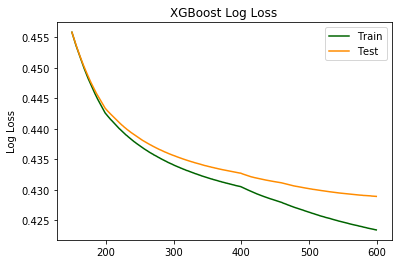

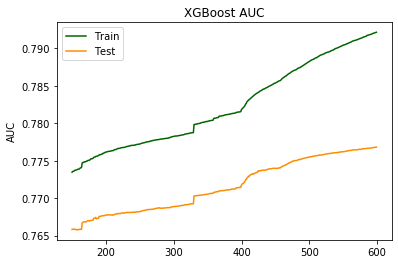

In [182]:
plot(seq_results, start=150)

### Test one XGBoost

In [274]:
weight = 1
margin=0
base_weight = y_train - 0.5*y_train* weight
base_margin = y_train* margin

In [280]:
y_train
base_weight = pd.Series(
    [1 for _ in range(y_train.shape[0])], index = y_train.index
)

In [299]:
base_weight[y_train==0]=1
base_weight[y_train==1]=10

In [300]:
base_weight

16831    10
4222      1
8736     10
27880     1
29290    10
         ..
29802     1
5390     10
860       1
15795    10
23654    10
Length: 20100, dtype: int64

In [301]:
xgb_model1 = XGBClassifier(n_estimators=200, learning_rate = 0.01, max_depth=3, reg_lambda =0, base_score=0.5)
xgb_model1.fit(X_train,y_train, sample_weight = base_weight)

xgb_model2 = XGBClassifier(n_estimators=200, learning_rate = 0.01, max_depth=3, reg_lambda =0,  base_score=0.5)
xgb_model2.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=0, scale_pos_weight=1, subsample=1, tree_method=None,
              validate_parameters=False, verbosity=None)

In [302]:
proba_train_1 = xgb_model1.predict_proba(X_train)[:,1]
proba_test_1 = xgb_model1.predict_proba(X_test)[:,1]

proba_train_2 = xgb_model2.predict_proba(X_train)[:,1]
proba_test_2 = xgb_model2.predict_proba(X_test)[:,1]

In [303]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import numpy as np

In [304]:
def plot_metrics(y_true, y_pred, ax = None, label = 'label', color='red'):
    
    if ax is None:
        fig, ax = plt.subplots(1,2,figsize=(16,8))
   
    fpr, tpr, _ = roc_curve(y_true,y_pred)
    roc_auc = np.round(auc(fpr, tpr),3)
    
    plt.figure()
    lw = 2
    ax[0].plot(fpr, tpr, color=color,
         lw=lw, label=f'{label} AUC: {roc_auc}')
    ax[0].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic example')
    ax[0].legend(loc="lower right")
    
    pr, rec, _ = precision_recall_curve(y_true,y_pred)
    
    plt.figure()
    lw = 2
    ax[1].plot(pr, rec, color=color,
         lw=lw, label=f'{label}')
    #ax[1].plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Precision')
    ax[1].set_ylabel('Recall')
    ax[1].set_title('Precision recall')
    ax[1].legend(loc="best")
    
    return None

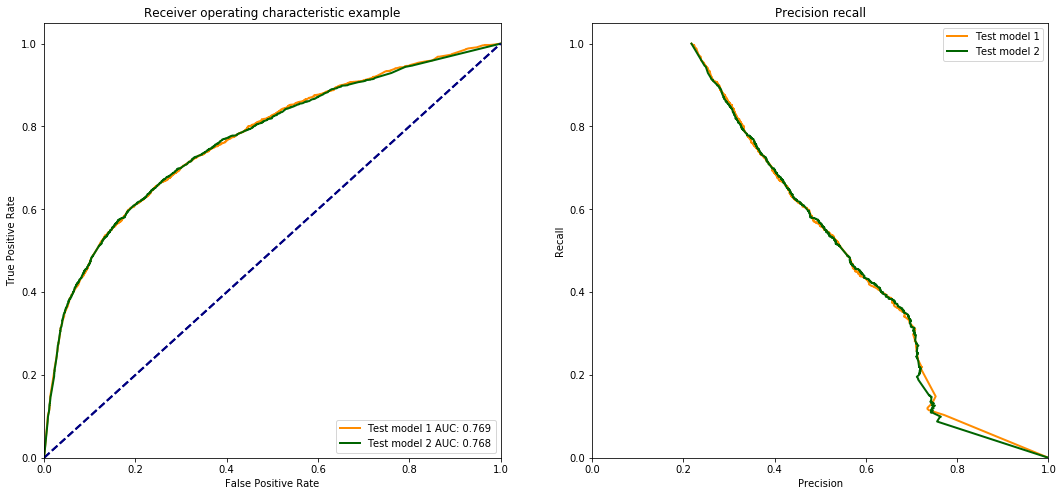

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [305]:
fig, ax = plt.subplots(1,2,figsize=(18,8))

# plot_metrics(y_train,proba_train_1, ax= ax, label = 'Train model 1', color='darkred' )
plot_metrics(y_test,proba_test_1, ax= ax, label = 'Test model 1', color='darkorange' )

# plot_metrics(y_train,proba_train_2, ax= ax, label = 'Train model 2', color='darkblue' )
plot_metrics(y_test,proba_test_2, ax= ax, label = 'Test model 2', color='darkgreen' )